In [1]:
# Install required packages
import sys, os
import numpy as np
import scipy.spatial as sp
from sklearn.preprocessing import normalize
from IPython.display import display, clear_output
from IPython.display import Markdown
import pandas as pd
from collections import namedtuple
from itertools import product, permutations
import matplotlib.pyplot as plt
import random
import copy
import ipympl

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import pyomo environment and setup gurobi solver
import pyomo.environ as pyo
import gurobipy 
solver = pyo.SolverFactory("gurobi_direct")

In [2]:
'''
Sample pertubations of instance
Args:     orig          - array of original instance
          index_list    - list with indices of originial array to perturb
          method        - method to perturb instance. Only option now: normal
          var           - variance for pertubation
          size          - number of perturbed instances
Output:   org_plus_smpl - array with rows original instance and size perturbed instances
'''

def sample_perturbations(orig, index_list, method = 'normal', var = 0.2, size = 1000):
    
    mean = 0
    var = 0.2
    eps = 0.1
    org_plus_prtb = []
    prtb = []
    
    for i in range(size):
        orig_with_noise = copy.deepcopy(orig)
        prtb.append([])
        
        for j in range(len(orig)):
            if j in index_list:
                if method == 'normal':
                    sigma = orig_with_noise[j] * var
                    orig_with_noise[j] = orig_with_noise[j] + np.random.normal(mean, sigma)
                elif method == 'epsilon':
                    lmb = np.random.uniform(-1, 1)
                    orig_with_noise[j] = orig_with_noise[j] + lmb * eps
                    prtb[i].append(lmb)
                elif method == 'scaling':
                    lmb = np.random.uniform(0.2, 1.8)
                    orig_with_noise[j] = orig_with_noise[j] * lmb 
                    prtb[i].append(lmb)
                else:
                    return print("Method not supported")
                    

        org_plus_prtb.append(np.asarray(orig_with_noise))
    org_plus_prtb = np.asarray(org_plus_prtb)
    prtb = np.asarray(prtb)

    return org_plus_prtb, prtb

In [3]:
# Compute distance between two vectors and evaluate the kernel function
# kernel_width: kernel width for the exponential kernel.
#                 If None, defaults to sqrt (number of columns) * 0.75

def distance(a, b):
    return np.linalg.norm(a - b)
    
def kernel(a, b, kernel_width = 0.5):
    d = distance(a, b)
    return np.exp(-(d ** 2) / (2* kernel_width ** 2))

In [4]:
# Create instances for Knapsack problem


# Instance 1: with logical features
KS_vals_1 = [9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 6]
KS_wgts_1 = [0.9, 0.02, 0.03, 0.01, 0.04, 0.005, 0.001, 0.015, 0.09, 0.0001]
KS_bdgt_1 = 1
# Concatenate variables
inst_1 = np.concatenate((KS_vals_1, KS_wgts_1, [KS_bdgt_1]))

# Instance 2: with correlated weights and values
KS_vals_2 = [0.1 , 0.21, 0.39, 0.101, 0.398, 0.0507, 0.01, 0.146, 0.188, 0.017]
KS_wgts_2 = [0.09, 0.2 , 0.3 , 0.1  , 0.4  , 0.05  , 0.01, 0.15 , 0.19 , 0.01]
KS_bdgt_2 = 1
# Concatenate variables
inst_2 = np.concatenate((KS_vals_2, KS_wgts_2, [KS_bdgt_2]))

# Instance 3: Random instance
np.random.seed(10)
KS_vals_3 = np.random.rand(10)
KS_wgts_3_tmp = np.random.rand(10)
KS_wgts_3 = KS_wgts_3_tmp / (0.9 * np.sum(KS_wgts_3_tmp))
KS_bdgt_3 = 1
# Concatenate variables
inst_3 = np.concatenate((KS_vals_3, KS_wgts_3, [KS_bdgt_3]))

In [5]:
# Binary LP knapsack
def model_KS_bin(vals, solver = solver):

    # Define a model
    model = pyo.ConcreteModel('Test KS')

    # Declare decision variables
    model.x = pyo.Var(range(int(((len(vals)-1)/2))), domain=pyo.Binary)

    # Declare objective
    model.objective = pyo.Objective(expr = sum(vals[i]*model.x[i] for i in range(int(((len(vals)-1)/2)))),
                                sense = pyo.maximize)

    # Declare constraints
    model.budget = pyo.Constraint(expr = sum(vals[i+int(((len(vals)-1)/2))]*model.x[i] for i in range(int(((len(vals)-1)/2)))) <= vals[-1])

    # Solve
    result = solver.solve(model)

    # Store solutions
    solutions = []
    for i in range(int(((len(vals)-1)/2))):
        solutions.append(pyo.value(model.x[i]))

    return model.objective(), solutions

In [6]:
# Continuous LP knapsack
def model_KS_cts(vals, solver = solver):

    # Define a model
    model = pyo.ConcreteModel('Test KS')

    # Declare decision variables
    model.x = pyo.Var(range(int(((len(vals)-1)/2))), domain=pyo.NonNegativeReals, bounds=(0, 1))

    # Declare objective
    model.objective = pyo.Objective(expr = sum(vals[i]*model.x[i] for i in range(int(((len(vals)-1)/2)))),
                                    sense = pyo.maximize)

    # Declare constraints
    model.budget = pyo.Constraint(expr = sum(vals[i+int(((len(vals)-1)/2))]*model.x[i] for i in range(int(((len(vals)-1)/2)))) <= vals[-1])

    # Solve
    result = solver.solve(model)

    # Store solutions
    solutions = []
    for i in range(int(((len(vals)-1)/2))):
        solutions.append(pyo.value(model.x[i]))

    return model.objective(), solutions

In [7]:
# Heuristic for Knapsack
def model_KS_hrs(vals, solver = solver):

    # Sort ratios
    arr = []
    for i in range(0, len(KS_wgts_1)):
        arr.append([vals[i], vals[i+len(KS_wgts_1)], i])

    arr.sort(key=lambda x: (x[0]/x[1]), reverse=True)

    # Result(value in Knapsack)
    finalvalue = 0.0
    W = vals[-1]
    solutions = np.zeros(len(KS_wgts_1))

    # Looping through all Items
    for item in arr:
    # If adding Item won't overflow, add it completely
        if item[1] <= W:
            W -= item[1]
            finalvalue += item[0]
            solutions[item[2]] = 1

        else:
            break

    # Returning final value and solution
    return finalvalue, solutions

In [8]:
# Print outcome of the three models applied to instance 1
print(model_KS_bin(inst_1))
print(model_KS_cts(inst_1))
print(model_KS_hrs(inst_1))

(18.0, [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, -0.0, 1.0])
(18.288999999999998, [0.9765555555555554, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0])
(9.5, array([0., 1., 1., 1., 1., 1., 1., 1., 0., 1.]))


In [9]:
# Create labels for features of instances
# Features for now: 

labels = []
for i in range(len(KS_vals_1)):
    labels.append(('Value_'+str(i)))
for i in range(len(KS_wgts_1)):
    labels.append(('Weight_'+str(i)))

labels.append('Budget')

features = [*range(20)]

# Explaining optimal value

## Parametric optimization + approximation

In [10]:
KS_wgts_1      = [0.9, 0.02, 0.03 , 0.01, 0.04 , 0.005, 0.001, 0.015, 0.09, 0.0001]
KS_wgts_1_prtb = [0.2, 0.01, 0.058, 0.02, 0.075, 0.009, 0.002, 0.028, 0.15, 0.0002]

smpl_sclr = np.random.uniform(-0.5,6,1000)
sol_org   = model_KS_bin(inst_1)[1]

smpl_csts_lp = []
smpl_csts_hr = []
smpl_fsbl = []
krnl_wdth = [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5]
smpl_wgts = np.zeros((len(krnl_wdth), len(smpl_sclr)))


for smpl in range(len(smpl_sclr)):
    locl_wgt_vct = np.array(KS_wgts_1) + smpl_sclr[smpl] * np.array(KS_wgts_1_prtb)
    locl_ins_vct = np.concatenate((KS_vals_1, locl_wgt_vct, [KS_bdgt_1]))
    smpl_csts_lp.append(model_KS_bin(locl_ins_vct)[0])  
    smpl_csts_hr.append(model_KS_hrs(locl_ins_vct)[0])  
    if  np.dot(sol_org, locl_ins_vct[10:-1]) <= 1:
        smpl_fsbl.append(1)
    else:
        smpl_fsbl.append(0)

    for w in range(len(krnl_wdth)):
        locl_wgt = kernel(0, smpl_sclr[smpl], krnl_wdth[w])
        smpl_wgts[w][smpl] = locl_wgt

In [11]:
x_test = np.linspace(start = -0.5, stop = 6.0, num=650).reshape(-1, 1)

y_rel_lp = []
y_rel_hr = []
y_fsb = []
for tst in x_test:
    locl_wgt_vct = np.array(KS_wgts_1) + tst * np.array(KS_wgts_1_prtb)
    locl_ins_vct = np.concatenate((KS_vals_1, locl_wgt_vct, [KS_bdgt_1]))
    y_rel_lp.append(model_KS_bin(locl_ins_vct)[0])
    y_rel_hr.append(model_KS_hrs(locl_ins_vct)[0])
    if  np.dot(sol_org, locl_ins_vct[10:-1]) <= 1:
        y_fsb.append(1)
    else:
        y_fsb.append(0)

C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_4240\3526138509.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  arr.sort(key=lambda x: (x[0]/x[1]), reverse=True)


In [12]:
outcome_d_lp = {}

for i in range(len(krnl_wdth)):
    DTR = DecisionTreeRegressor(max_depth=4)
    DTR.fit(np.array(smpl_sclr).reshape(-1, 1), np.array(smpl_csts_lp), sample_weight=np.array(smpl_wgts[i]))
    y_test = DTR.predict(x_test)
    outcome_d_lp[str(krnl_wdth[i]) + "DTR"] = y_test
    w_test = []
    for tst in x_test:
        w_test.append(kernel(tst, 0, krnl_wdth[i]))
    wMSE = mean_squared_error(y_rel_lp, y_test, sample_weight=w_test)
    lcl_MSE = mean_squared_error(y_rel_lp[:100], y_test[:100])
    print("DTR, Kernel size: "+  str(krnl_wdth[i]), ".  wMSE: "+str( wMSE), ".  local MSE: "+str( lcl_MSE))

DTR, Kernel size: 0.1 .  wMSE: 0.0002993638279584485 .  local MSE: 0.08062381588971922
DTR, Kernel size: 0.25 .  wMSE: 0.062418667665060656 .  local MSE: 0.07755919082554677
DTR, Kernel size: 0.5 .  wMSE: 0.05994819289137714 .  local MSE: 0.07684426150747192
DTR, Kernel size: 0.75 .  wMSE: 0.0505337502227705 .  local MSE: 0.07757949173011322
DTR, Kernel size: 1 .  wMSE: 0.008239532589468366 .  local MSE: 0.015125172471463015
DTR, Kernel size: 1.25 .  wMSE: 0.007274660997981797 .  local MSE: 0.015119384184917522
DTR, Kernel size: 1.5 .  wMSE: 0.00652050654951215 .  local MSE: 0.015116458445849065


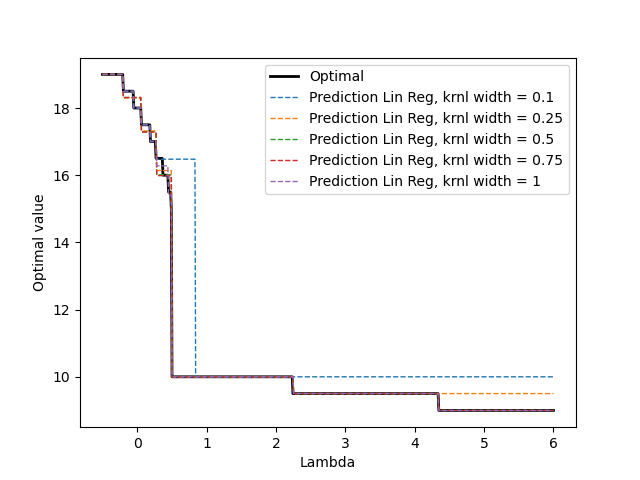

In [13]:
fig = plt.figure()
plt.plot(x_test, y_rel_lp, color = 'black', linestyle = '-', label = "Optimal", linewidth =2) 
for kr_w in krnl_wdth[:-2]:
    plt.plot(x_test, outcome_d_lp[str(str(kr_w)+ "DTR")], label = 'Prediction Lin Reg, krnl width = ' + str(kr_w), linestyle = '--', linewidth =1) 

plt.legend() 
plt.xlabel("Lambda")
plt.ylabel("Optimal value") 
plt.show()

In [14]:
for i in range(len(krnl_wdth)):
    clf = LinearRegression()
    clf.fit(np.array(smpl_sclr).reshape(-1, 1), np.array(smpl_csts_lp), sample_weight=np.array(smpl_wgts[i]))
    y_test = clf.predict(x_test)
    outcome_d_lp[str(krnl_wdth[i])] = y_test
    w_test = []
    for tst in x_test:
        w_test.append(kernel(tst, 0, krnl_wdth[i]))
    wMSE = mean_squared_error(y_rel_lp, y_test, sample_weight=w_test)
    lcl_MSE = mean_squared_error(y_rel_lp[:100], y_test[:100])
    print("Lin Reg. Kernel size: "+  str(krnl_wdth[i]), ".  wMSE: "+str( wMSE), ".  local MSE: "+str( lcl_MSE))

Lin Reg. Kernel size: 0.1 .  wMSE: 0.023115635715310213 .  local MSE: 0.16955891432910034
Lin Reg. Kernel size: 0.25 .  wMSE: 0.6870120273119162 .  local MSE: 0.23357889838126428
Lin Reg. Kernel size: 0.5 .  wMSE: 2.076938934545078 .  local MSE: 1.1648751669911752
Lin Reg. Kernel size: 0.75 .  wMSE: 2.9494145970389907 .  local MSE: 0.9469093954612078
Lin Reg. Kernel size: 1 .  wMSE: 4.085712348113822 .  local MSE: 1.0651528010104663
Lin Reg. Kernel size: 1.25 .  wMSE: 5.05277893792524 .  local MSE: 1.7623214222130263
Lin Reg. Kernel size: 1.5 .  wMSE: 5.741120549065364 .  local MSE: 2.933364643425353


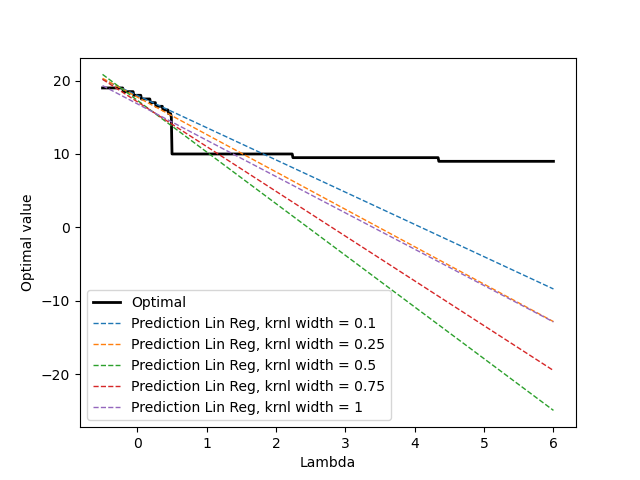

In [15]:
fig = plt.figure()
plt.plot(x_test, y_rel_lp, color = 'black', linestyle = '-', label = "Optimal", linewidth =2) 
for kr_w in krnl_wdth[:-2]:
    plt.plot(x_test, outcome_d_lp[str(str(kr_w))], label = 'Prediction Lin Reg, krnl width = ' + str(kr_w), linestyle = '--', linewidth =1) 

plt.legend() 
plt.xlabel("Lambda")
plt.ylabel("Optimal value") 
plt.show()

In [16]:
outcome_d_hr = {}

for i in range(len(krnl_wdth)):
    DTR = DecisionTreeRegressor(max_depth=4)
    DTR.fit(np.array(smpl_sclr).reshape(-1, 1), np.array(smpl_csts_hr), sample_weight=np.array(smpl_wgts[i]))
    y_test = DTR.predict(x_test)
    outcome_d_hr[str(krnl_wdth[i]) + "DTR"] = y_test
    w_test = []
    for tst in x_test:
        w_test.append(kernel(tst, 0, krnl_wdth[i]))
    wMSE = mean_squared_error(y_rel_hr, y_test, sample_weight=w_test)
    lcl_MSE = mean_squared_error(y_rel_hr[:100], y_test[:100])
    print("DTR, Kernel size: "+  str(krnl_wdth[i]), ".  wMSE: "+str( wMSE), ".  local MSE: "+str( lcl_MSE))

DTR, Kernel size: 0.1 .  wMSE: 0.0027323287307731005 .  local MSE: 0.0025
DTR, Kernel size: 0.25 .  wMSE: 0.003319108310421267 .  local MSE: 0.0024999999999999645
DTR, Kernel size: 0.5 .  wMSE: 0.002248072509769357 .  local MSE: 0.0024999999999999823
DTR, Kernel size: 0.75 .  wMSE: 0.11539292176378334 .  local MSE: 0.10639235556379602
DTR, Kernel size: 1 .  wMSE: 0.0014223787916678012 .  local MSE: 0.002500000000000018
DTR, Kernel size: 1.25 .  wMSE: 0.0012064499437564895 .  local MSE: 0.002500000000000018
DTR, Kernel size: 1.5 .  wMSE: 0.0010479841990657915 .  local MSE: 0.0025


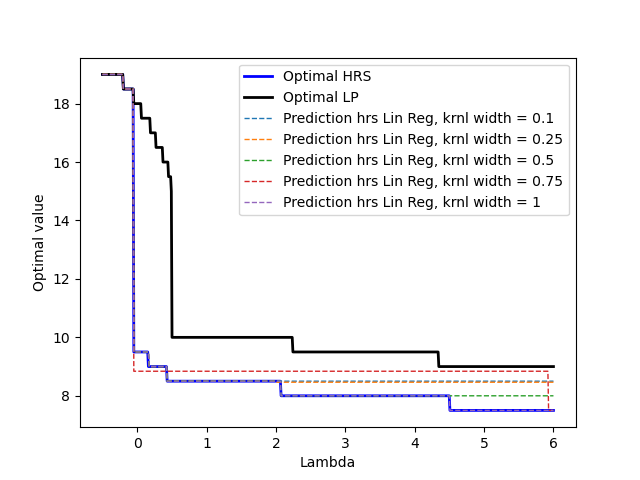

In [17]:
fig = plt.figure()
plt.plot(x_test, y_rel_hr, color = 'blue', linestyle = '-', label = "Optimal HRS", linewidth =2) 
plt.plot(x_test, y_rel_lp, color = 'black', linestyle = '-', label = "Optimal LP", linewidth =2) 
for kr_w in krnl_wdth[:-2]:
    plt.plot(x_test, outcome_d_hr[str(str(kr_w)+ "DTR")], label = 'Prediction hrs Lin Reg, krnl width = ' + str(kr_w), linestyle = '--', linewidth =1) 

plt.legend() 
plt.xlabel("Lambda")
plt.ylabel("Optimal value") 
plt.show()

In [18]:
fsb_d = {}

for i in range(len(krnl_wdth)):
    DTR = DecisionTreeRegressor(max_depth=4)
    DTR.fit(np.array(smpl_sclr).reshape(-1, 1), np.array(smpl_fsbl), sample_weight=np.array(smpl_wgts[i]))
    y_test = DTR.predict(x_test)
    fsb_d[str(krnl_wdth[i]) + "DTR"] = y_test
    w_test = []
    for tst in x_test:
        w_test.append(kernel(tst, 0, krnl_wdth[i]))
    wMSE = mean_squared_error(y_fsb, y_test, sample_weight=w_test)
    lcl_MSE = mean_squared_error(y_fsb[:100], y_test[:100])
    print("DTR, Kernel size: "+  str(krnl_wdth[i]), ".  wMSE: "+str( wMSE), ".  local MSE: "+str( lcl_MSE))

DTR, Kernel size: 0.1 .  wMSE: 0.0 .  local MSE: 0.0
DTR, Kernel size: 0.25 .  wMSE: 0.0 .  local MSE: 0.0
DTR, Kernel size: 0.5 .  wMSE: 0.0 .  local MSE: 0.0
DTR, Kernel size: 0.75 .  wMSE: 0.0 .  local MSE: 0.0
DTR, Kernel size: 1 .  wMSE: 0.0 .  local MSE: 0.0
DTR, Kernel size: 1.25 .  wMSE: 0.0 .  local MSE: 0.0
DTR, Kernel size: 1.5 .  wMSE: 0.0 .  local MSE: 0.0


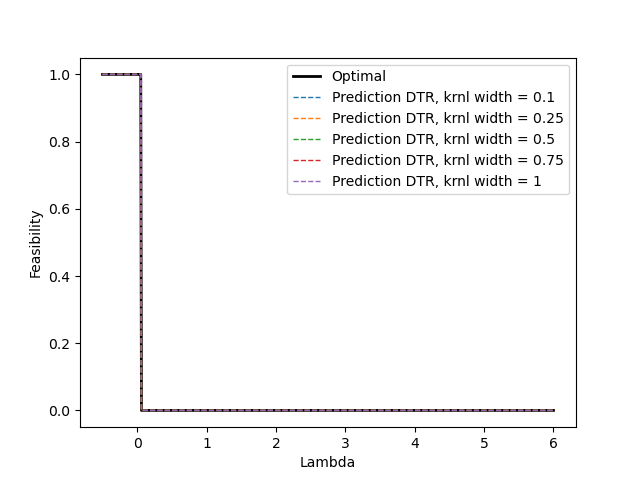

In [19]:
fig = plt.figure()
plt.plot(x_test, y_fsb, color = 'black', linestyle = '-', label = "Optimal", linewidth =2) 
for kr_w in krnl_wdth[:-2]:
    plt.plot(x_test, fsb_d[str(kr_w)+ "DTR" ], label = 'Prediction DTR, krnl width = ' + str(kr_w), linestyle = '--', linewidth =1) 

plt.legend() 
plt.xlabel("Lambda")
plt.ylabel("Feasibility") 
plt.show()

In [20]:
for i in range(len(krnl_wdth)):
    LGR = LogisticRegression()
    LGR.fit(np.array(smpl_sclr).reshape(-1, 1), np.array(smpl_fsbl), sample_weight=np.array(smpl_wgts[i]))
    y_test = LGR.predict(x_test)
    fsb_d[str(krnl_wdth[i])] = y_test
    w_test = []
    for tst in x_test:
        w_test.append(kernel(tst, 0, krnl_wdth[i]))
    wMSE = mean_squared_error(y_fsb, y_test, sample_weight=w_test)
    lcl_MSE = mean_squared_error(y_fsb[:100], y_test[:100])
    print("DTR, Kernel size: "+  str(krnl_wdth[i]), ".  wMSE: "+str( wMSE), ".  local MSE: "+str( lcl_MSE))

DTR, Kernel size: 0.1 .  wMSE: 0.2876050934418824 .  local MSE: 0.27
DTR, Kernel size: 0.25 .  wMSE: 0.016002076235078863 .  local MSE: 0.01
DTR, Kernel size: 0.5 .  wMSE: 0.018861359259096756 .  local MSE: 0.02
DTR, Kernel size: 0.75 .  wMSE: 0.021287183459611392 .  local MSE: 0.03
DTR, Kernel size: 1 .  wMSE: 0.01727626416646009 .  local MSE: 0.03
DTR, Kernel size: 1.25 .  wMSE: 0.014589912052104718 .  local MSE: 0.03
DTR, Kernel size: 1.5 .  wMSE: 0.01264360106606923 .  local MSE: 0.03


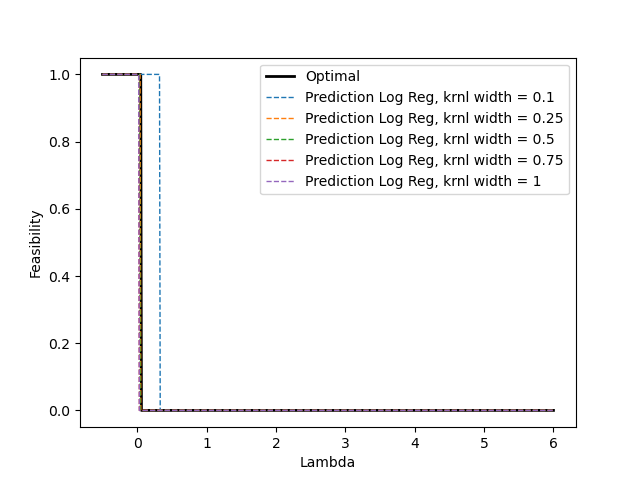

In [21]:
fig = plt.figure()
plt.plot(x_test, y_fsb, color = 'black', linestyle = '-', label = "Optimal", linewidth =2) 
for kr_w in krnl_wdth[:-2]:
    plt.plot(x_test, fsb_d[str(kr_w)], label = 'Prediction Log Reg, krnl width = ' + str(kr_w), linestyle = '--', linewidth =1) 

plt.legend() 
plt.xlabel("Lambda")
plt.ylabel("Feasibility") 
plt.show()

## All paramaters

In [22]:
# Create perturbations of instance 1
smpl_1_A, prt_1_A = sample_perturbations(inst_1, features, method='normal')
smpl_1_B, prt_1_B = sample_perturbations(inst_1, features, method='epsilon')
smpl_1_C, prt_1_C = sample_perturbations(inst_1, features, method='scaling')

def store_wgts(smpl, prt, method, wdth):
    outp = []
    for i in range(len(smpl)):
        if method == 'normal':
            outp.append(kernel(np.array(inst_1), smpl[i], wdth))
        elif method == 'epsilon':
            outp.append(kernel(np.zeros(len(prt[i])), prt[i], wdth))
        elif method == 'scaling':
            outp.append(kernel(np.ones(len(prt[i])), prt[i], wdth))
    return outp


krnl_wdth = [.5, 0.75, 1, 1.5, 2]
wgts_A = {}
wgts_B = {}
wgts_C = {}
for i in range(len(krnl_wdth)):
    wgts_A[str(krnl_wdth[i])] = store_wgts(smpl_1_A, prt_1_A, 'normal', krnl_wdth[i])
    wgts_B[str(krnl_wdth[i])] = store_wgts(smpl_1_B, prt_1_B, 'epsilon', krnl_wdth[i])
    wgts_C[str(krnl_wdth[i])] = store_wgts(smpl_1_C, prt_1_C, 'scaling', krnl_wdth[i])


def store_sol(smpl):
    # Arrays for storing solutions for perturbed values
    sol_bin = []
    sol_cts = []
    sol_hrs = []

    # Arrays for storing objective value for perturbed values
    obj_bin = []
    obj_cts = []
    obj_hrs = []

    for i in range(len(smpl)):
        
        full_sol_bin = model_KS_bin(smpl[i])
        full_sol_cts = model_KS_cts(smpl[i])
        full_sol_hrs = model_KS_hrs(smpl[i])

        obj_bin.append(full_sol_bin[0])
        obj_cts.append(full_sol_cts[0])
        obj_hrs.append(full_sol_hrs[0])

        sol_bin.append(full_sol_bin[1])
        sol_cts.append(full_sol_cts[1])
        sol_hrs.append(full_sol_hrs[1])

    return obj_bin, obj_cts, obj_hrs, sol_bin, sol_cts, sol_hrs

obj_bin_A, obj_cts_A, obj_hrs_A, sol_bin_A, sol_cts_A, sol_hrs_A = store_sol(smpl_1_A)
obj_bin_B, obj_cts_B, obj_hrs_B, sol_bin_B, sol_cts_B, sol_hrs_B = store_sol(smpl_1_B)
obj_bin_C, obj_cts_C, obj_hrs_C, sol_bin_C, sol_cts_C, sol_hrs_C = store_sol(smpl_1_C)

In [79]:
def splitter(X, y, method, ftrs, kernels = krnl_wdth):
    X_train, X_test, y_train, y_test =  train_test_split(X[:,ftrs], y,
                                                    train_size = 0.8, 
                                                    test_size = 0.2, 
                                                    random_state = 100)
    ins_wgt_trn = np.zeros((len(kernels),len(X_train)))
    ins_wgt_tst = np.zeros((len(kernels),len(X_test)))
    for w in range(len(kernels)):
        for xt in range(len(X_train)):
            if method == 'normal':
                ins_wgt_trn[w][xt] = kernel(inst_1[ftrs], X_train[xt], kernels[w])
            elif method == 'epsilon':
                ins_wgt_trn[w][xt] = kernel(np.zeros(len(X_train[xt])), X_train[xt], kernels[w])
            elif method == 'scalar':
                ins_wgt_trn[w][xt] = kernel( np.ones(len(X_train[xt])), X_train[xt], kernels[w])
            else:
                print('Wrong input')
        for xt in range(len(X_test)):
            if method == 'normal':
                ins_wgt_tst[w][xt] = kernel(inst_1[ftrs], X_test[xt], kernels[w])
            elif method == 'epsilon':
                ins_wgt_tst[w][xt] = kernel(np.zeros(len(X_test[xt])), X_test[xt], kernels[w])
            elif method == 'scalar':
                ins_wgt_tst[w][xt] = kernel( np.ones(len(X_test[xt])), X_test[xt], kernels[w])
            else:
                print('Wrong input')

    return X_train, X_test, y_train, y_test, ins_wgt_trn, ins_wgt_tst
    

def linear_models(X, y, method, ftrs, kernels = krnl_wdth, alphas=[0.1, 0.5, 1, 1.5, 2]):
    X_train, X_test, y_train, y_test, w_train, w_test = splitter(X, y, method, ftrs, kernels)

    model_frml = []
    model_type = []
    score      = []

    for i in range(len(kernels)):
        clf_LR    = LinearRegression()
        clf_LR.fit(X_train, y_train, sample_weight=w_train[i])
        print('LinReg. Kern ' + str(kernels[i]), clf_LR.coef_)
        y_pred    = clf_LR.predict(X_test)

        score.append(mean_squared_error(y_test, y_pred, sample_weight = w_test[i]))
        model_type.append('LinReg. Kern ' + str(kernels[i]))
        model_frml.append(copy.deepcopy(clf_LR))

        for alph in alphas:
            clf_RDG = Ridge(alpha=alph)        
            clf_RDG.fit(X_train, y_train, sample_weight=np.array(w_train[i]))
            y_pred = clf_RDG.predict(X_test)

            score.append(mean_squared_error(y_test, y_pred, sample_weight = w_test[i]))
            model_type.append('Ridge ' + str(alph) + '. Kern ' + str(kernels[i]))
            model_frml.append(copy.deepcopy(clf_RDG))


            clf_LSS = Lasso(alpha=alph)        
            clf_LSS.fit(X_train, y_train, sample_weight=np.array(w_train[i]))
            y_pred = clf_LSS.predict(X_test)
            
            score.append(mean_squared_error(y_test, y_pred, sample_weight = w_test[i]))
            model_type.append('Lasso ' + str(alph) + '. Kern ' + str(kernels[i]))
            model_frml.append(copy.deepcopy(clf_LSS))

    best_score = np.min(score)
    best_model_type = model_type[np.argmin(score)]
    best_model      = model_frml[np.argmin(score)]
           
    return best_model, best_model_type, best_score 



In [24]:
def check_fsb_opt(smpl_set, sol_bin, sol_cts, sol_hrs):

    # Initial solutions
    int_sol_bin = model_KS_bin(inst_1)[1]
    int_sol_cts = model_KS_cts(inst_1)[1]
    int_sol_hrs = model_KS_hrs(inst_1)[1]

    # Array checking whether original solution stays feasible
    fsb_bin = np.zeros(len(smpl_set))
    fsb_cts = np.zeros(len(smpl_set))
    fsb_hrs = np.zeros(len(smpl_set))

    for i in range(len(smpl_set)):
        smpl = smpl_set[i]
        
        if np.dot(int_sol_bin, smpl[10:-1]) <= 1:
            fsb_bin[i] = 1
        if np.dot(int_sol_cts, smpl[10:-1]) <= 1:
            fsb_cts[i] = 1
        if np.dot(int_sol_hrs, smpl[10:-1]) <= 1:
            fsb_hrs[i] = 1

    # Array checking whether original solution stays optimal
    opt_bin = np.zeros(len(smpl_set))
    opt_cts = np.zeros(len(smpl_set))
    opt_hrs = np.zeros(len(smpl_set))

    for i in range(len(smpl_set)):
        if int_sol_bin == sol_bin[i]:
            opt_bin[i] = 1
        if int_sol_bin == sol_cts[i]:
            opt_cts[i] = 1
        if sol_hrs[0].all() == sol_hrs[i].all():
            opt_hrs[i] = 1

    return fsb_bin, fsb_cts, fsb_hrs, opt_bin, opt_cts, opt_hrs

fsb_bin_A, fsb_cts_A, fsb_hrs_A, opt_bin_A, opt_cts_A, opt_hrs_A = check_fsb_opt(smpl_1_A, sol_bin_A, sol_cts_A, sol_hrs_A)
fsb_bin_B, fsb_cts_B, fsb_hrs_B, opt_bin_B, opt_cts_B, opt_hrs_B = check_fsb_opt(smpl_1_B, sol_bin_B, sol_cts_B, sol_hrs_B)
fsb_bin_C, fsb_cts_C, fsb_hrs_C, opt_bin_C, opt_cts_C, opt_hrs_C = check_fsb_opt(smpl_1_C, sol_bin_C, sol_cts_C, sol_hrs_C)

In [25]:
bm_A_bin_obj, mt_A_bin_obj, score_A_bin_obj = linear_models(smpl_1_A, obj_bin_A,'normal', features)
bm_B_bin_obj, mt_B_bin_obj, score_B_bin_obj = linear_models(smpl_1_B, obj_bin_B,'epsilon', features)
bm_C_bin_obj, mt_C_bin_obj, score_C_bin_obj = linear_models(smpl_1_C, obj_bin_C,'scalar', features)
bm_A_cts_obj, mt_A_cts_obj, score_A_cts_obj = linear_models(smpl_1_A, obj_cts_A,'normal', features)
bm_B_cts_obj, mt_B_cts_obj, score_B_cts_obj = linear_models(smpl_1_B, obj_cts_B,'epsilon', features)
bm_C_cts_obj, mt_C_cts_obj, score_C_cts_obj = linear_models(smpl_1_C, obj_cts_C,'scalar', features)
bm_A_hrs_obj, mt_A_hrs_obj, score_A_hrs_obj = linear_models(smpl_1_A, obj_hrs_A,'normal', features)
bm_B_hrs_obj, mt_B_hrs_obj, score_B_hrs_obj = linear_models(smpl_1_B, obj_hrs_B,'epsilon', features)
bm_C_hrs_obj, mt_C_hrs_obj, score_C_hrs_obj = linear_models(smpl_1_C, obj_hrs_C,'scalar', features)
print('Normal, 01KS'  , mt_A_bin_obj)
print('Epsilon, 01KS' , mt_B_bin_obj)
print('Scalar, 01KS'  , mt_C_bin_obj)
print('Normal, ctsKS' , mt_A_cts_obj)
print('Epsilon, ctsKS', mt_B_cts_obj)
print('Scalar, ctsKS' , mt_C_cts_obj)
print('Normal, hrs'   , mt_A_hrs_obj)
print('Epsilon, hrs'  , mt_B_hrs_obj)
print('Scalar, hrs'   , mt_C_hrs_obj)

Normal, 01KS Ridge 0.1. Kern 2
Epsilon, 01KS LinReg. Kern 0.5
Scalar, 01KS LinReg. Kern 0.75
Normal, ctsKS Ridge 0.1. Kern 0.5
Epsilon, ctsKS LinReg. Kern 0.75
Scalar, ctsKS LinReg. Kern 0.5
Normal, hrs Lasso 0.1. Kern 0.5
Epsilon, hrs LinReg. Kern 1
Scalar, hrs LinReg. Kern 0.75


In [80]:
print(features[10:])
bm_A_bin_obj, mt_A_bin_obj, score_A_bin_obj = linear_models(smpl_1_A, obj_bin_A,'normal', features[10:])

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
LinReg. Kern 0.1 [-2.39040958e+01  3.83728129e+00 -1.04425616e+01  1.35879102e+01
 -1.04934752e+01  9.03997696e+01 -1.80966339e+02 -4.75003633e-01
  1.75797193e+00 -5.88474277e+03]
LinReg. Kern 0.25 [-1.93972645e+01  2.39522887e+00  1.96487312e+00  2.47504719e+00
 -4.03907013e+00  5.09229127e+01  1.90179760e+02 -2.92514664e+01
  2.05907060e+00 -6.23342003e+03]
LinReg. Kern 0.5 [-1.74482191e+01  2.64655115e+00  1.80985686e+00 -3.04200725e+00
 -1.76201366e+00  3.47315983e+01  3.22084904e+02 -4.83828051e+01
  1.76988524e+00 -5.63869522e+03]
LinReg. Kern 0.75 [-1.70331966e+01  3.09380017e+00  1.22268213e+00 -4.15558829e+00
 -1.13645743e+00  3.11084600e+01  3.60012883e+02 -5.35542540e+01
  1.65351718e+00 -5.48633557e+03]
LinReg. Kern 1 [-1.68837994e+01  3.30564469e+00  9.55164576e-01 -4.54894034e+00
 -8.92592986e-01  2.97878180e+01  3.74980528e+02 -5.55336632e+01
  1.60356684e+00 -5.42980153e+03]
LinReg. Kern 1.25 [-1.68139236e+01  3.41492367e+00  8.

In [78]:
for i in range(10,20):
    print(i, np.corrcoef(smpl_1_A[:,i], obj_bin_A)[0,1])

10 -0.7306495782224323
11 -0.012809263071385971
12 -0.001582960639155407
13 0.017855231995377575
14 -0.005351270461544349
15 0.02795657804027685
16 0.010499584200615305
17 -0.023175942697278632
18 0.005243846433616509
19 -0.005122725231727805


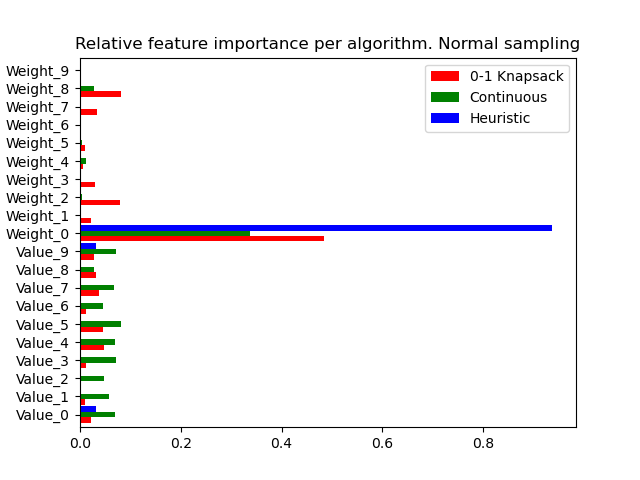

In [26]:
import matplotlib.pyplot as plt

# Normalize coefficients to get feature importance
ftr_imp_bin_1 = np.abs(bm_A_bin_obj.coef_)/np.sum(np.abs(bm_A_bin_obj.coef_))
ftr_imp_cts_1 = np.abs(bm_A_cts_obj.coef_)/np.sum(np.abs(bm_A_cts_obj.coef_))
ftr_imp_hrs_1 = np.abs(bm_A_hrs_obj.coef_)/np.sum(np.abs(bm_A_hrs_obj.coef_))

# Plot feature importance
ind = np.arange(len(features))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, ftr_imp_bin_1, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, ftr_imp_cts_1, width, color='green', label='Continuous')
ax.barh(ind + 2*width, ftr_imp_hrs_1, width, color='blue', label='Heuristic')

ax.set(yticks=ind + width, yticklabels=np.array(labels)[features], ylim=[2*width - 1, len(features)])
ax.legend()
plt.title('Relative feature importance per algorithm. Normal sampling')
plt.show()

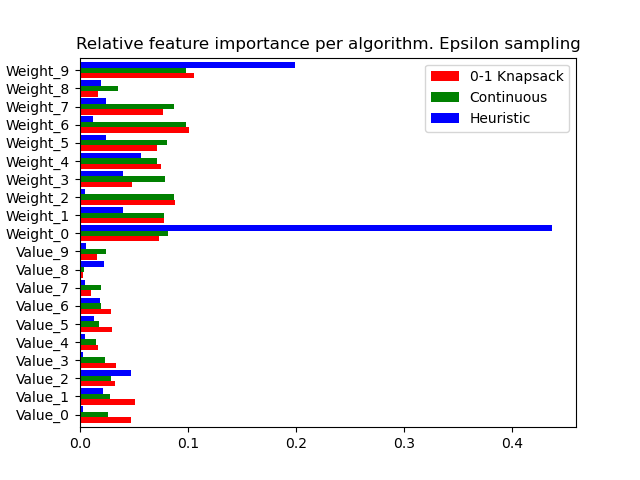

In [27]:
# Normalize coefficients to get feature importance
ftr_imp_bin_1 = np.abs(bm_B_bin_obj.coef_)/np.sum(np.abs(bm_B_bin_obj.coef_))
ftr_imp_cts_1 = np.abs(bm_B_cts_obj.coef_)/np.sum(np.abs(bm_B_cts_obj.coef_))
ftr_imp_hrs_1 = np.abs(bm_B_hrs_obj.coef_)/np.sum(np.abs(bm_B_hrs_obj.coef_))

# Plot feature importance
ind = np.arange(len(features))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, ftr_imp_bin_1, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, ftr_imp_cts_1, width, color='green', label='Continuous')
ax.barh(ind + 2*width, ftr_imp_hrs_1, width, color='blue', label='Heuristic')

ax.set(yticks=ind + width, yticklabels=np.array(labels)[features], ylim=[2*width - 1, len(features)])
ax.legend()
plt.title('Relative feature importance per algorithm. Epsilon sampling')
plt.show()

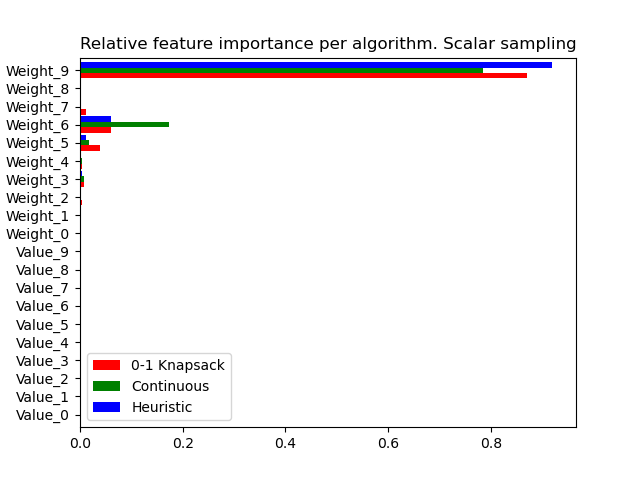

In [28]:
# Normalize coefficients to get feature importance
ftr_imp_bin_1 = np.abs(bm_C_bin_obj.coef_)/np.sum(np.abs(bm_C_bin_obj.coef_))
ftr_imp_cts_1 = np.abs(bm_C_cts_obj.coef_)/np.sum(np.abs(bm_C_cts_obj.coef_))
ftr_imp_hrs_1 = np.abs(bm_C_hrs_obj.coef_)/np.sum(np.abs(bm_C_hrs_obj.coef_))

# Plot feature importance
ind = np.arange(len(features))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, ftr_imp_bin_1, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, ftr_imp_cts_1, width, color='green', label='Continuous')
ax.barh(ind + 2*width, ftr_imp_hrs_1, width, color='blue', label='Heuristic')

ax.set(yticks=ind + width, yticklabels=np.array(labels)[features], ylim=[2*width - 1, len(features)])
ax.legend()
plt.title('Relative feature importance per algorithm. Scalar sampling')
plt.show()

## Only weight (constraint) parameters

### Linear Regression

In [29]:
sub_ftrs = features[10:]

sub_bm_A_bin_obj, sub_mt_A_bin_obj, sub_score_A_bin_obj = linear_models(smpl_1_A, obj_bin_A,'normal', sub_ftrs)
sub_bm_B_bin_obj, sub_mt_B_bin_obj, sub_score_B_bin_obj = linear_models(smpl_1_B, obj_bin_B,'epsilon', sub_ftrs)
sub_bm_C_bin_obj, sub_mt_C_bin_obj, sub_score_C_bin_obj = linear_models(smpl_1_C, obj_bin_C,'scalar', sub_ftrs)
sub_bm_A_cts_obj, sub_mt_A_cts_obj, sub_score_A_cts_obj = linear_models(smpl_1_A, obj_cts_A,'normal', sub_ftrs)
sub_bm_B_cts_obj, sub_mt_B_cts_obj, sub_score_B_cts_obj = linear_models(smpl_1_B, obj_cts_B,'epsilon', sub_ftrs)
sub_bm_C_cts_obj, sub_mt_C_cts_obj, sub_score_C_cts_obj = linear_models(smpl_1_C, obj_cts_C,'scalar', sub_ftrs)
sub_bm_A_hrs_obj, sub_mt_A_hrs_obj, sub_score_A_hrs_obj = linear_models(smpl_1_A, obj_hrs_A,'normal', sub_ftrs)
sub_bm_B_hrs_obj, sub_mt_B_hrs_obj, sub_score_B_hrs_obj = linear_models(smpl_1_B, obj_hrs_B,'epsilon', sub_ftrs)
sub_bm_C_hrs_obj, sub_mt_C_hrs_obj, sub_score_C_hrs_obj = linear_models(smpl_1_C, obj_hrs_C,'scalar', sub_ftrs)
print('Normal, 01KS'  , sub_mt_A_bin_obj)
print('Epsilon, 01KS' , sub_mt_B_bin_obj)
print('Scalar, 01KS'  , sub_mt_C_bin_obj)
print('Normal, ctsKS' , sub_mt_A_cts_obj)
print('Epsilon, ctsKS', sub_mt_B_cts_obj)
print('Scalar, ctsKS' , sub_mt_C_cts_obj)
print('Normal, hrs'   , sub_mt_A_hrs_obj)
print('Epsilon, hrs'  , sub_mt_B_hrs_obj)
print('Scalar, hrs'   , sub_mt_C_hrs_obj)

Normal, 01KS Ridge 0.1. Kern 0.5
Epsilon, 01KS LinReg. Kern 0.5
Scalar, 01KS Lasso 0.1. Kern 2
Normal, ctsKS Ridge 0.5. Kern 0.5
Epsilon, ctsKS LinReg. Kern 0.5
Scalar, ctsKS Lasso 0.1. Kern 0.5
Normal, hrs Ridge 0.5. Kern 0.5
Epsilon, hrs LinReg. Kern 0.5
Scalar, hrs Lasso 0.1. Kern 2


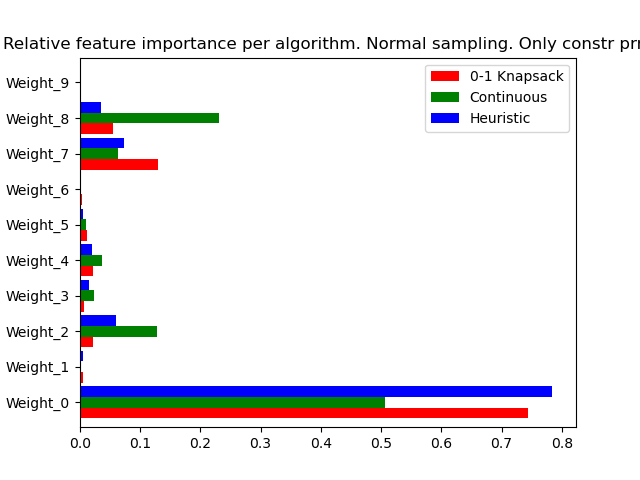

In [30]:
# Normalize coefficients to get feature importance
ftr_imp_bin_1 = np.abs(sub_bm_A_bin_obj.coef_)/np.sum(np.abs(sub_bm_A_bin_obj.coef_))
ftr_imp_cts_1 = np.abs(sub_bm_A_cts_obj.coef_)/np.sum(np.abs(sub_bm_A_cts_obj.coef_))
ftr_imp_hrs_1 = np.abs(sub_bm_A_hrs_obj.coef_)/np.sum(np.abs(sub_bm_A_hrs_obj.coef_))

# Plot feature importance
ind = np.arange(len(sub_ftrs))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, ftr_imp_bin_1, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, ftr_imp_cts_1, width, color='green', label='Continuous')
ax.barh(ind + 2*width, ftr_imp_hrs_1, width, color='blue', label='Heuristic')

ax.set(yticks=ind + width, yticklabels=np.array(labels)[sub_ftrs], ylim=[2*width - 1, len(sub_ftrs)])
ax.legend()
plt.title('Relative feature importance per algorithm. Normal sampling. Only constr prm')
plt.show()

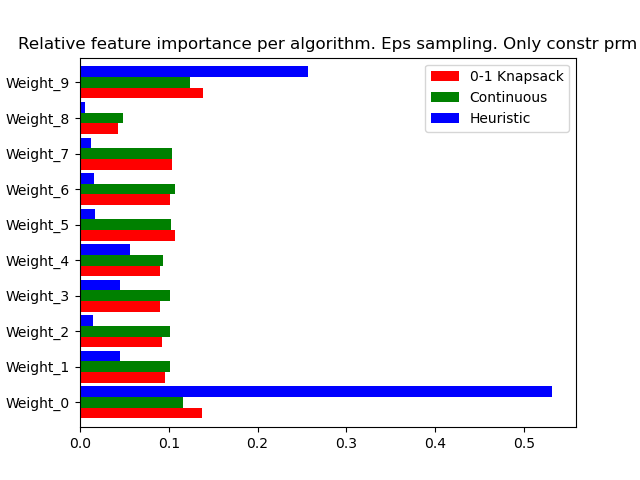

In [31]:
# Normalize coefficients to get feature importance
ftr_imp_bin_1 = np.abs(sub_bm_B_bin_obj.coef_)/np.sum(np.abs(sub_bm_B_bin_obj.coef_))
ftr_imp_cts_1 = np.abs(sub_bm_B_cts_obj.coef_)/np.sum(np.abs(sub_bm_B_cts_obj.coef_))
ftr_imp_hrs_1 = np.abs(sub_bm_B_hrs_obj.coef_)/np.sum(np.abs(sub_bm_B_hrs_obj.coef_))

# Plot feature importance
ind = np.arange(len(sub_ftrs))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, ftr_imp_bin_1, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, ftr_imp_cts_1, width, color='green', label='Continuous')
ax.barh(ind + 2*width, ftr_imp_hrs_1, width, color='blue', label='Heuristic')

ax.set(yticks=ind + width, yticklabels=np.array(labels)[sub_ftrs], ylim=[2*width - 1, len(sub_ftrs)])
ax.legend()
plt.title('Relative feature importance per algorithm. Eps sampling. Only constr prm')
plt.show()

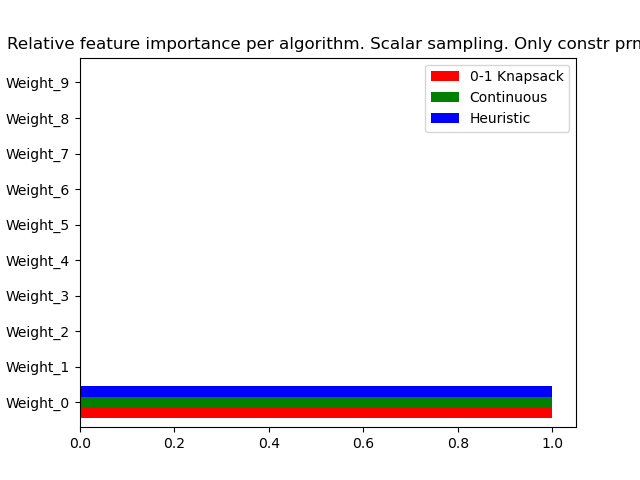

In [32]:
# Normalize coefficients to get feature importance
ftr_imp_bin_1 = np.abs(sub_bm_C_bin_obj.coef_)/np.sum(np.abs(sub_bm_C_bin_obj.coef_))
ftr_imp_cts_1 = np.abs(sub_bm_C_cts_obj.coef_)/np.sum(np.abs(sub_bm_C_cts_obj.coef_))
ftr_imp_hrs_1 = np.abs(sub_bm_C_hrs_obj.coef_)/np.sum(np.abs(sub_bm_C_hrs_obj.coef_))

# Plot feature importance
ind = np.arange(len(sub_ftrs))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, ftr_imp_bin_1, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, ftr_imp_cts_1, width, color='green', label='Continuous')
ax.barh(ind + 2*width, ftr_imp_hrs_1, width, color='blue', label='Heuristic')

ax.set(yticks=ind + width, yticklabels=np.array(labels)[sub_ftrs], ylim=[2*width - 1, len(sub_ftrs)])
ax.legend()
plt.title('Relative feature importance per algorithm. Scalar sampling. Only constr prm')
plt.show()

### Decision Tree

In [33]:
def tree_models(X, y, method, ftrs, kernels = krnl_wdth, depths=[2,3,4,5], msl = [50, 100, 150]):
    X_train, X_test, y_train, y_test, w_train, w_test = splitter(X, y, method, ftrs, kernels)

    model_frml = []
    model_type = []
    score      = []

    for i in range(len(kernels)):
        for d in depths:
            for m in msl:
                DTR = DecisionTreeRegressor(random_state=0, max_depth=d, min_samples_leaf=m)     
                DTR.fit(X_train, y_train, sample_weight=np.array(w_train[i]))
                y_pred = DTR.predict(X_test)

                score.append(mean_squared_error(y_test, y_pred, sample_weight = w_test[i]))
                model_type.append('Tree. Max depth ' + str(d) + '. Min Sample Leaf ' + str(m) + '. kernel ' + str(kernels[i]))
                model_frml.append(copy.deepcopy(DTR))

    best_score = np.min(score)
    best_model_type = model_type[np.argmin(score)]
    best_model      = model_frml[np.argmin(score)]
           
    return best_model, best_model_type, best_score 

In [34]:
bm_A_bin_obj_tree, mt_A_bin_obj_tree, score_A_bin_obj_tree = tree_models(smpl_1_A, obj_bin_A,'normal', sub_ftrs)
bm_B_bin_obj_tree, mt_B_bin_obj_tree, score_B_bin_obj_tree = tree_models(smpl_1_B, obj_bin_B,'epsilon', sub_ftrs)
bm_C_bin_obj_tree, mt_C_bin_obj_tree, score_C_bin_obj_tree = tree_models(smpl_1_C, obj_bin_C,'scalar', sub_ftrs)
bm_A_cts_obj_tree, mt_A_cts_obj_tree, score_A_cts_obj_tree = tree_models(smpl_1_A, obj_cts_A,'normal', sub_ftrs)
bm_B_cts_obj_tree, mt_B_cts_obj_tree, score_B_cts_obj_tree = tree_models(smpl_1_B, obj_cts_B,'epsilon', sub_ftrs)
bm_C_cts_obj_tree, mt_C_cts_obj_tree, score_C_cts_obj_tree = tree_models(smpl_1_C, obj_cts_C,'scalar', sub_ftrs)
bm_A_hrs_obj_tree, mt_A_hrs_obj_tree, score_A_hrs_obj_tree = tree_models(smpl_1_A, obj_hrs_A,'normal', sub_ftrs)
bm_B_hrs_obj_tree, mt_B_hrs_obj_tree, score_B_hrs_obj_tree = tree_models(smpl_1_B, obj_hrs_B,'epsilon', sub_ftrs)
bm_C_hrs_obj_tree, mt_C_hrs_obj_tree, score_C_hrs_obj_tree = tree_models(smpl_1_C, obj_hrs_C,'scalar', sub_ftrs)
print('Normal, 01KS'  , mt_A_bin_obj_tree)
print('Epsilon, 01KS' , mt_B_bin_obj_tree)
print('Scalar, 01KS'  , mt_C_bin_obj_tree)
print('Normal, ctsKS' , mt_A_cts_obj_tree)
print('Epsilon, ctsKS', mt_B_cts_obj_tree)
print('Scalar, ctsKS' , mt_C_cts_obj_tree)
print('Normal, hrs'   , mt_A_hrs_obj_tree)
print('Epsilon, hrs'  , mt_B_hrs_obj_tree)
print('Scalar, hrs'   , mt_C_hrs_obj_tree)

Normal, 01KS Tree. Max depth 3. Min Sample Leaf 100. kernel 2
Epsilon, 01KS Tree. Max depth 5. Min Sample Leaf 50. kernel 0.5
Scalar, 01KS Tree. Max depth 2. Min Sample Leaf 50. kernel 0.5
Normal, ctsKS Tree. Max depth 2. Min Sample Leaf 150. kernel 0.5
Epsilon, ctsKS Tree. Max depth 5. Min Sample Leaf 50. kernel 0.5
Scalar, ctsKS Tree. Max depth 2. Min Sample Leaf 50. kernel 0.75
Normal, hrs Tree. Max depth 3. Min Sample Leaf 100. kernel 2
Epsilon, hrs Tree. Max depth 5. Min Sample Leaf 50. kernel 0.5
Scalar, hrs Tree. Max depth 2. Min Sample Leaf 100. kernel 0.5


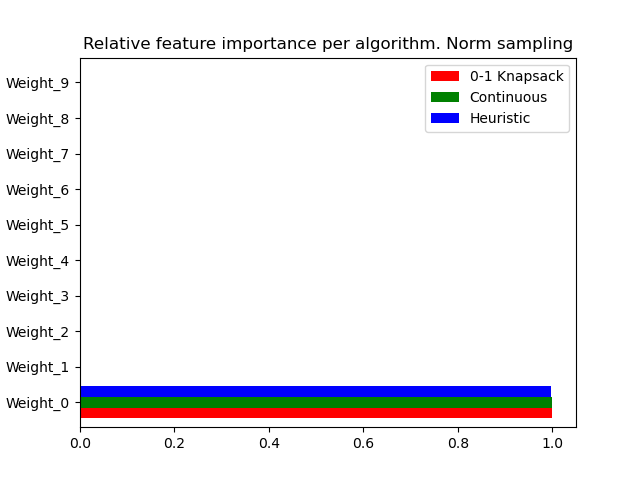

In [35]:
# Plot feature importance of decision tree
ind = np.arange(len(sub_ftrs))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, bm_A_bin_obj_tree.feature_importances_, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, bm_A_cts_obj_tree.feature_importances_, width, color='green', label='Continuous')
ax.barh(ind + 2*width, bm_A_hrs_obj_tree.feature_importances_, width, color='blue', label='Heuristic')

ax.set(yticks=ind + width, yticklabels=np.array(labels)[sub_ftrs], ylim=[2*width - 1, len(sub_ftrs)])
ax.legend()
plt.title('Relative feature importance per algorithm. Norm sampling')
plt.show()

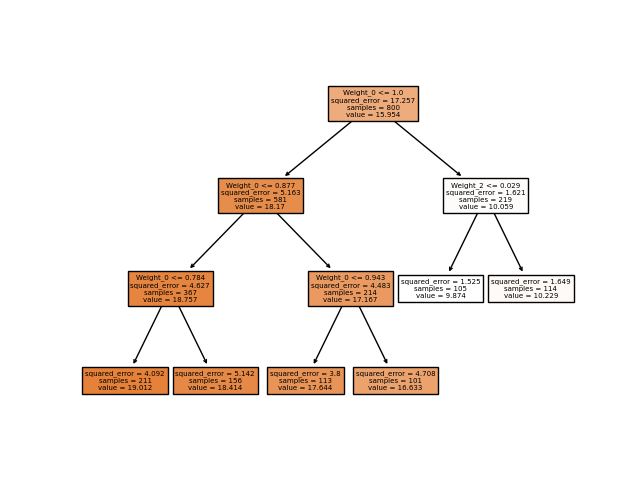

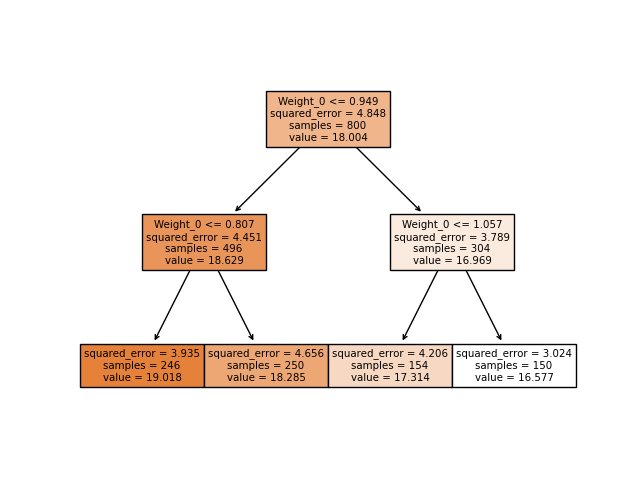

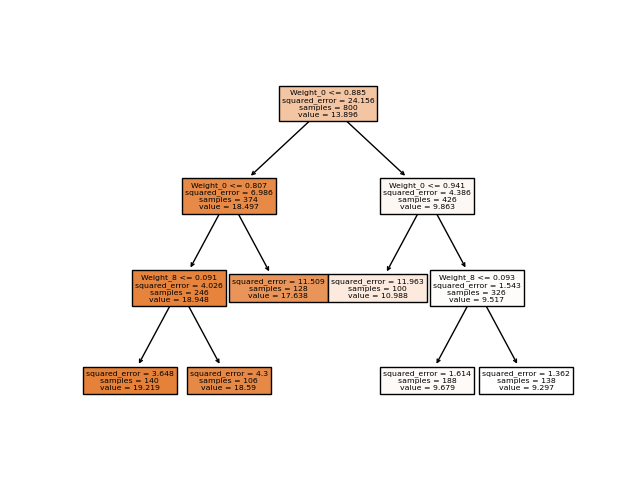

In [36]:
# Plot decision tree itself

from sklearn.tree import plot_tree

plt.figure()
plot_tree(bm_A_bin_obj_tree, filled=True, feature_names = np.array(labels)[sub_ftrs])
plt.show()
plot_tree(bm_A_cts_obj_tree, filled=True, feature_names = np.array(labels)[sub_ftrs])
plt.show()
plot_tree(bm_A_hrs_obj_tree, filled=True, feature_names = np.array(labels)[sub_ftrs])
plt.show()

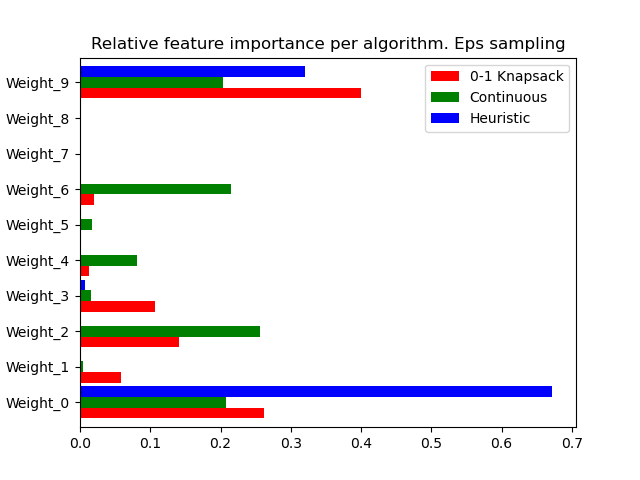

In [37]:
# Plot feature importance of decision tree
ind = np.arange(len(sub_ftrs))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, bm_B_bin_obj_tree.feature_importances_, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, bm_B_cts_obj_tree.feature_importances_, width, color='green', label='Continuous')
ax.barh(ind + 2*width, bm_B_hrs_obj_tree.feature_importances_, width, color='blue', label='Heuristic')

ax.set(yticks=ind + width, yticklabels=np.array(labels)[sub_ftrs], ylim=[2*width - 1, len(sub_ftrs)])
ax.legend()
plt.title('Relative feature importance per algorithm. Eps sampling')
plt.show()

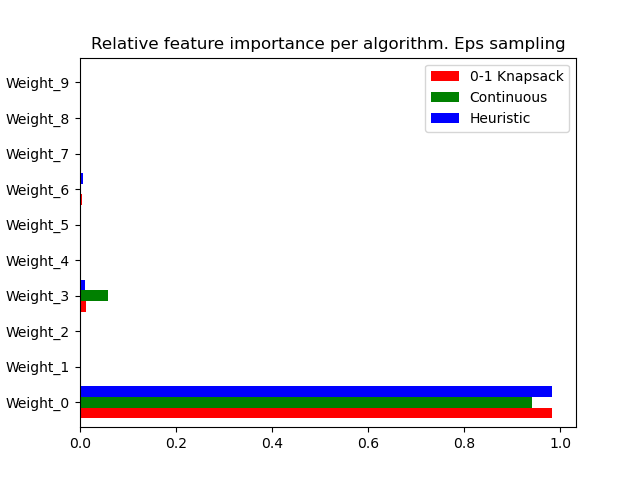

In [38]:
# Plot feature importance of decision tree
ind = np.arange(len(sub_ftrs))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, bm_C_bin_obj_tree.feature_importances_, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, bm_C_cts_obj_tree.feature_importances_, width, color='green', label='Continuous')
ax.barh(ind + 2*width, bm_C_hrs_obj_tree.feature_importances_, width, color='blue', label='Heuristic')

ax.set(yticks=ind + width, yticklabels=np.array(labels)[sub_ftrs], ylim=[2*width - 1, len(sub_ftrs)])
ax.legend()
plt.title('Relative feature importance per algorithm. Eps sampling')
plt.show()

# Explaining feasibility of original solution

## With trees

In [39]:
bm_A_bin_fsb_tree, mt_A_bin_fsb_tree, score_A_bin_fsb_tree = tree_models(smpl_1_A, fsb_bin_A,'normal', sub_ftrs)
bm_B_bin_fsb_tree, mt_B_bin_fsb_tree, score_B_bin_fsb_tree = tree_models(smpl_1_B, fsb_bin_B,'epsilon', sub_ftrs)
bm_C_bin_fsb_tree, mt_C_bin_fsb_tree, score_C_bin_fsb_tree = tree_models(smpl_1_C, fsb_bin_C,'scalar', sub_ftrs)
bm_A_cts_fsb_tree, mt_A_cts_fsb_tree, score_A_cts_fsb_tree = tree_models(smpl_1_A, fsb_cts_A,'normal', sub_ftrs)
bm_B_cts_fsb_tree, mt_B_cts_fsb_tree, score_B_cts_fsb_tree = tree_models(smpl_1_B, fsb_cts_B,'epsilon', sub_ftrs)
bm_C_cts_fsb_tree, mt_C_cts_fsb_tree, score_C_cts_fsb_tree = tree_models(smpl_1_C, fsb_cts_C,'scalar', sub_ftrs)
bm_A_hrs_fsb_tree, mt_A_hrs_fsb_tree, score_A_hrs_fsb_tree = tree_models(smpl_1_A, fsb_hrs_A,'normal', sub_ftrs)
bm_B_hrs_fsb_tree, mt_B_hrs_fsb_tree, score_B_hrs_fsb_tree = tree_models(smpl_1_B, fsb_hrs_B,'epsilon', sub_ftrs)
bm_C_hrs_fsb_tree, mt_C_hrs_fsb_tree, score_C_hrs_fsb_tree = tree_models(smpl_1_C, fsb_hrs_C,'scalar', sub_ftrs)
print('Normal, 01KS'  , mt_A_bin_fsb_tree)
print('Epsilon, 01KS' , mt_B_bin_fsb_tree)
print('Scalar, 01KS'  , mt_C_bin_fsb_tree)
print('Normal, ctsKS' , mt_A_cts_fsb_tree)
print('Epsilon, ctsKS', mt_B_cts_fsb_tree)
print('Scalar, ctsKS' , mt_C_cts_fsb_tree)
print('Normal, hrs'   , mt_A_hrs_fsb_tree)
print('Epsilon, hrs'  , mt_B_hrs_fsb_tree)
print('Scalar, hrs'   , mt_C_hrs_fsb_tree)

Normal, 01KS Tree. Max depth 2. Min Sample Leaf 50. kernel 2
Epsilon, 01KS Tree. Max depth 5. Min Sample Leaf 50. kernel 0.5
Scalar, 01KS Tree. Max depth 2. Min Sample Leaf 150. kernel 2
Normal, ctsKS Tree. Max depth 2. Min Sample Leaf 50. kernel 2
Epsilon, ctsKS Tree. Max depth 3. Min Sample Leaf 50. kernel 1
Scalar, ctsKS Tree. Max depth 2. Min Sample Leaf 50. kernel 2
Normal, hrs Tree. Max depth 2. Min Sample Leaf 50. kernel 0.5
Epsilon, hrs Tree. Max depth 2. Min Sample Leaf 50. kernel 0.5
Scalar, hrs Tree. Max depth 2. Min Sample Leaf 50. kernel 0.5


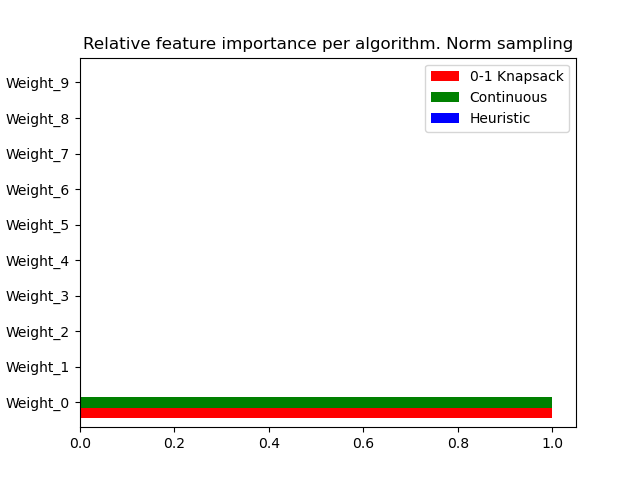

In [40]:
# Plot feature importance of decision tree
ind = np.arange(len(sub_ftrs))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, bm_A_bin_fsb_tree.feature_importances_, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, bm_A_cts_fsb_tree.feature_importances_, width, color='green', label='Continuous')
ax.barh(ind + 2*width, bm_A_hrs_fsb_tree.feature_importances_, width, color='blue', label='Heuristic')

ax.set(yticks=ind + width, yticklabels=np.array(labels)[sub_ftrs], ylim=[2*width - 1, len(sub_ftrs)])
ax.legend()
plt.title('Relative feature importance per algorithm. Norm sampling')
plt.show()

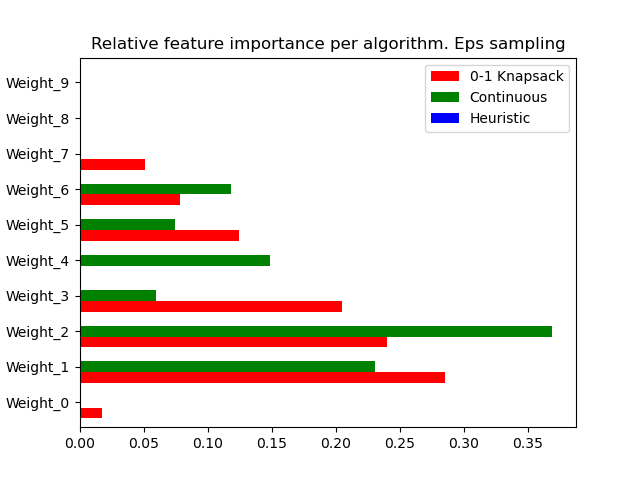

In [41]:
# Plot feature importance of decision tree
ind = np.arange(len(sub_ftrs))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, bm_B_bin_fsb_tree.feature_importances_, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, bm_B_cts_fsb_tree.feature_importances_, width, color='green', label='Continuous')
ax.barh(ind + 2*width, bm_B_hrs_fsb_tree.feature_importances_, width, color='blue', label='Heuristic')

ax.set(yticks=ind + width, yticklabels=np.array(labels)[sub_ftrs], ylim=[2*width - 1, len(sub_ftrs)])
ax.legend()
plt.title('Relative feature importance per algorithm. Eps sampling')
plt.show()

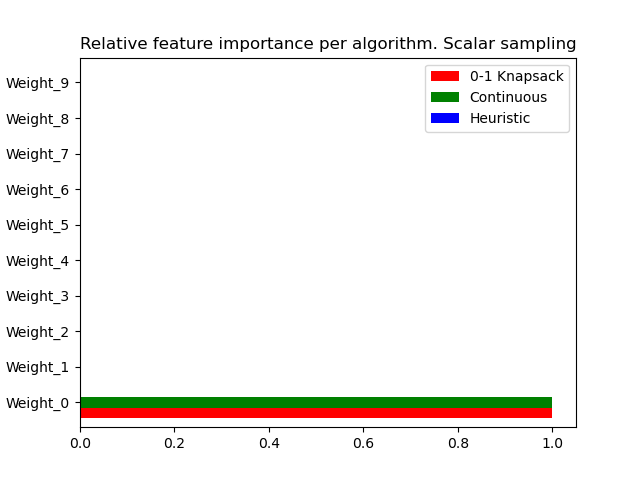

In [42]:
# Plot feature importance of decision tree
ind = np.arange(len(sub_ftrs))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, bm_C_bin_fsb_tree.feature_importances_, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, bm_C_cts_fsb_tree.feature_importances_, width, color='green', label='Continuous')
ax.barh(ind + 2*width, bm_C_hrs_fsb_tree.feature_importances_, width, color='blue', label='Heuristic')

ax.set(yticks=ind + width, yticklabels=np.array(labels)[sub_ftrs], ylim=[2*width - 1, len(sub_ftrs)])
ax.legend()
plt.title('Relative feature importance per algorithm. Scalar sampling')
plt.show()

## Logistic regression

In [43]:
from sklearn.linear_model import LogisticRegression


def log_models(X, y, method, ftrs, kernels = krnl_wdth):
    X_train, X_test, y_train, y_test, w_train, w_test = splitter(X, y, method, ftrs, kernels)

    model_frml = []
    model_type = []
    score      = []

    for i in range(len(kernels)):
        LogReg = LogisticRegression()  
        LogReg.fit(X_train, y_train, sample_weight=np.array(w_train[i]))
        y_pred = LogReg.predict(X_test)

        score.append(mean_squared_error(y_test, y_pred, sample_weight = w_test[i]))
        model_type.append('Log. Reg. ' + 'Kernel size:' + str(kernels[i]))
        model_frml.append(copy.deepcopy(LogReg))

    best_score = np.min(score)
    best_model_type = model_type[np.argmin(score)]
    best_model      = model_frml[np.argmin(score)]
           
    return best_model, best_model_type, best_score 

In [44]:
bm_A_bin_fsb_logreg, mt_A_bin_fsb_logreg, score_A_bin_fsb_logreg = log_models(smpl_1_A, fsb_bin_A,'normal', sub_ftrs)
bm_B_bin_fsb_logreg, mt_B_bin_fsb_logreg, score_B_bin_fsb_logreg = log_models(smpl_1_B, fsb_bin_B,'epsilon', sub_ftrs)
bm_C_bin_fsb_logreg, mt_C_bin_fsb_logreg, score_C_bin_fsb_logreg = log_models(smpl_1_C, fsb_bin_C,'scalar', sub_ftrs)
bm_A_cts_fsb_logreg, mt_A_cts_fsb_logreg, score_A_cts_fsb_logreg = log_models(smpl_1_A, fsb_cts_A,'normal', sub_ftrs)
bm_B_cts_fsb_logreg, mt_B_cts_fsb_logreg, score_B_cts_fsb_logreg = log_models(smpl_1_B, fsb_cts_B,'epsilon', sub_ftrs)
bm_C_cts_fsb_logreg, mt_C_cts_fsb_logreg, score_C_cts_fsb_logreg = log_models(smpl_1_C, fsb_cts_C,'scalar', sub_ftrs)
print('Normal, 01KS'  , mt_A_bin_fsb_logreg)
print('Epsilon, 01KS' , mt_B_bin_fsb_logreg)
print('Scalar, 01KS'  , mt_C_bin_fsb_logreg)
print('Normal, ctsKS' , mt_A_cts_fsb_logreg)
print('Epsilon, ctsKS', mt_B_cts_fsb_logreg)
print('Scalar, ctsKS' , mt_C_cts_fsb_logreg)

Normal, 01KS Log. Reg. Kernel size:2
Epsilon, 01KS Log. Reg. Kernel size:2
Scalar, 01KS Log. Reg. Kernel size:1
Normal, ctsKS Log. Reg. Kernel size:2
Epsilon, ctsKS Log. Reg. Kernel size:1
Scalar, ctsKS Log. Reg. Kernel size:2


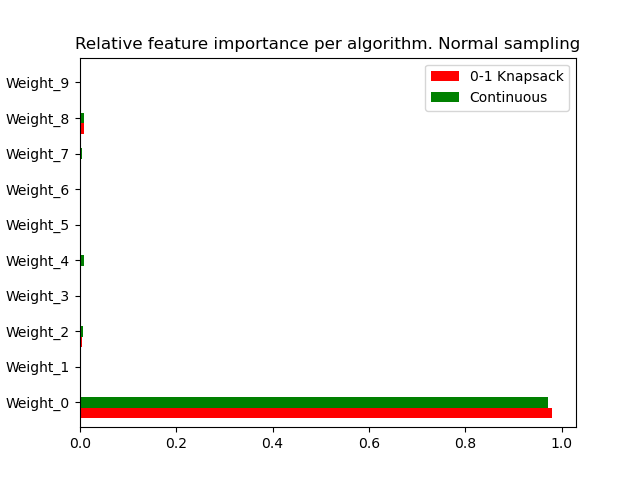

In [45]:
# Normalize coefficients to get feature importance
ftr_imp_bin_1 = np.abs(bm_A_bin_fsb_logreg.coef_[0])/np.sum(np.abs(bm_A_bin_fsb_logreg.coef_[0]))
ftr_imp_cts_1 = np.abs(bm_A_cts_fsb_logreg.coef_[0])/np.sum(np.abs(bm_A_cts_fsb_logreg.coef_[0]))

# Plot feature importance of decision tree
ind = np.arange(len(sub_ftrs))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, ftr_imp_bin_1, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, ftr_imp_cts_1, width, color='green', label='Continuous')
ax.set(yticks=ind + width, yticklabels=np.array(labels)[sub_ftrs], ylim=[2*width - 1, len(sub_ftrs)])
ax.legend()
plt.title('Relative feature importance per algorithm. Normal sampling')
plt.show()

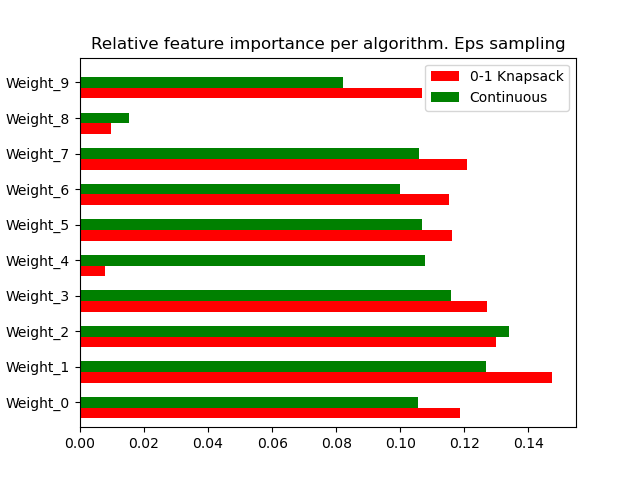

In [46]:
# Normalize coefficients to get feature importance
ftr_imp_bin_1 = np.abs(bm_B_bin_fsb_logreg.coef_[0])/np.sum(np.abs(bm_B_bin_fsb_logreg.coef_[0]))
ftr_imp_cts_1 = np.abs(bm_B_cts_fsb_logreg.coef_[0])/np.sum(np.abs(bm_B_cts_fsb_logreg.coef_[0]))

# Plot feature importance of decision tree
ind = np.arange(len(sub_ftrs))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, ftr_imp_bin_1, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, ftr_imp_cts_1, width, color='green', label='Continuous')
ax.set(yticks=ind + width, yticklabels=np.array(labels)[sub_ftrs], ylim=[2*width - 1, len(sub_ftrs)])
ax.legend()
plt.title('Relative feature importance per algorithm. Eps sampling')
plt.show()

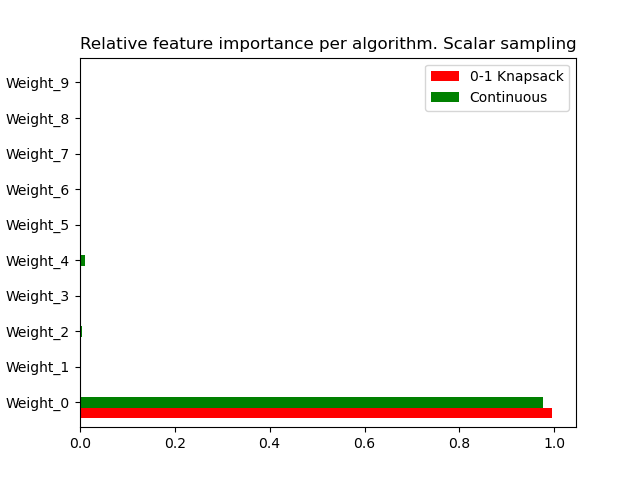

In [47]:
# Normalize coefficients to get feature importance
ftr_imp_bin_1 = np.abs(bm_C_bin_fsb_logreg.coef_[0])/np.sum(np.abs(bm_C_bin_fsb_logreg.coef_[0]))
ftr_imp_cts_1 = np.abs(bm_C_cts_fsb_logreg.coef_[0])/np.sum(np.abs(bm_C_cts_fsb_logreg.coef_[0]))

# Plot feature importance of decision tree
ind = np.arange(len(sub_ftrs))
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, ftr_imp_bin_1, width, color='red', label='0-1 Knapsack')
ax.barh(ind + width, ftr_imp_cts_1, width, color='green', label='Continuous')
ax.set(yticks=ind + width, yticklabels=np.array(labels)[sub_ftrs], ylim=[2*width - 1, len(sub_ftrs)])
ax.legend()
plt.title('Relative feature importance per algorithm. Scalar sampling')
plt.show()

# Explaining optimality original decision

In [48]:
# # Fit a log regression on wheter original solution remains optimal
# from sklearn.linear_model import LogisticRegression

# logr_bin_opt_1 = LogisticRegression(random_state=0)
# logr_bin_opt_1.fit(smpl_1[:,features], opt_bin_1, sample_weight=wgts_1)

# logr_cts_opt_1 = LogisticRegression(random_state=0)
# logr_cts_opt_1.fit(smpl_1[:,features], opt_cts_1, sample_weight=wgts_1)

# # Normalize coefficients to get feature importance
# logr_ftr_imp_opt_bin_1 = np.abs(logr_bin_opt_1.coef_[0])/np.sum(np.abs(logr_bin_opt_1.coef_[0]))
# logr_ftr_imp_opt_cts_1 = np.abs(logr_cts_opt_1.coef_[0])/np.sum(np.abs(logr_cts_opt_1.coef_[0]))

# # Plot feature importance
# ind = np.arange(len(features))
# width = 0.3

# fig, ax = plt.subplots()
# ax.barh(ind, logr_ftr_imp_opt_bin_1, width, color='red', label='0-1 Knapsack')
# ax.barh(ind + width, logr_ftr_imp_opt_cts_1, width, color='green', label='Continuous')
# ax.set(yticks=ind + width, yticklabels=np.array(labels)[features], ylim=[2*width - 1, len(features)])
# ax.legend()
# plt.title('Relative feature importance per algorithm')
# plt.show()

### linear knapsack

In [62]:
instance_val = np.array([0.8, 0.2, 0.4])
instance_wgt = np.array([0.8, 0.2, 0.25])
instance_prt = np.array([0  , 0.1, 0.05])

options = np.array([[0,0,0], [1,0,0], [0,1,0], [0,0,1],
                    [1,1,0], [1,0,1], [0,1,1], [1,1,1]])

In [63]:
x_test = np.linspace(-2, 2, 200)

best_cmb = []
best_cmb_cts = []

for x in x_test:
    instance_lcl = instance_wgt + x * instance_prt
    best_v = -1
    best_o = -1
    for i in range(len(options)):
        if np.dot(instance_lcl, options[i]) <= 1:
            val = np.dot(instance_wgt, options[i])
            if val > best_v:
                best_v = val
                best_o = options[i]
    best_cmb.append(best_o)

    locl_ins_vct = np.concatenate((instance_val, instance_lcl, [KS_bdgt_1]))
    best_cmb_cts.append(model_KS_cts(locl_ins_vct)[1])
    

best_ind = [row[1] for row in best_cmb]
best_ind_cts = [row[1] for row in best_cmb_cts]

In [64]:
outcome_d = {}

smpl_sclr = np.random.uniform(-2.0, 2.0, 100)
smpl_cmbn = []
krnl_wdth = [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5]
smpl_wgts = np.zeros((len(krnl_wdth), len(smpl_sclr)))


for smpl in range(len(smpl_sclr)):
    for w in range(len(krnl_wdth)):
        locl_wgt = kernel(0, smpl_sclr[smpl], krnl_wdth[w])
        smpl_wgts[w][smpl] = locl_wgt
    
    instance_lcl = instance_wgt + smpl_sclr[smpl] * instance_prt
    best_v = -1
    best_o = -1
    for i in range(len(options)):
        if np.dot(instance_lcl, options[i]) <= 1:
            val = np.dot(instance_wgt, options[i])
            if val > best_v:
                best_v = val
                best_o = options[i]
    smpl_cmbn.append(best_o)

smpl_ind = [row[1] for row in smpl_cmbn]

for i in range(len(krnl_wdth)):
    clf = LogisticRegression()
    clf.fit(np.array(smpl_sclr).reshape(-1, 1), np.array(smpl_ind), sample_weight=np.array(smpl_wgts[i]))
    y_test = clf.predict(np.array(x_test).reshape(-1, 1))
    outcome_d[str(krnl_wdth[i])] = y_test
    w_test = []
    for tst in x_test:
        w_test.append(kernel(tst, 0, krnl_wdth[i]))
    wMSE = mean_squared_error(best_ind, y_test, sample_weight=w_test)
    lcl_MSE = mean_squared_error(best_ind[50:-50], y_test[50:-50])
    print("Log Reg. Kernel size: "+  str(krnl_wdth[i]), ".  wMSE: "+str( wMSE), ".  local MSE: "+str( lcl_MSE))

for i in range(len(krnl_wdth)):
    DRT = DecisionTreeRegressor(max_depth=4)
    DRT.fit(np.array(smpl_sclr).reshape(-1, 1), np.array(smpl_ind), sample_weight=np.array(smpl_wgts[i]))
    y_test = DRT.predict(np.array(x_test).reshape(-1, 1))
    outcome_d[str(krnl_wdth[i]) + 'DRT'] = y_test
    w_test = []
    for tst in x_test:
        w_test.append(kernel(tst, 0, krnl_wdth[i]))
    wMSE = mean_squared_error(best_ind, y_test, sample_weight=w_test)
    lcl_MSE = mean_squared_error(best_ind[50:-50], y_test[50:-50])
    print("DRT Kernel size: "+  str(krnl_wdth[i]), ".  wMSE: "+str( wMSE), ".  local MSE: "+str( lcl_MSE))

for i in range(len(krnl_wdth)):
    SVM = svm.SVC()
    SVM.fit(np.array(smpl_sclr).reshape(-1, 1), np.array(smpl_ind), sample_weight=np.array(smpl_wgts[i]))
    y_test = SVM.predict(np.array(x_test).reshape(-1, 1))
    outcome_d[str(krnl_wdth[i]) + 'SVM'] = y_test
    w_test = []
    for tst in x_test:
        w_test.append(kernel(tst, 0, krnl_wdth[i]))
    wMSE = mean_squared_error(best_ind, y_test, sample_weight=w_test)
    lcl_MSE = mean_squared_error(best_ind[50:-50], y_test[50:-50])
    print("SVM Kernel size: "+  str(krnl_wdth[i]), ".  wMSE: "+str( wMSE), ".  local MSE: "+str( lcl_MSE))

Log Reg. Kernel size: 0.1 .  wMSE: 0.49999999999999994 .  local MSE: 0.5
Log Reg. Kernel size: 0.25 .  wMSE: 0.4878634828294217 .  local MSE: 0.28
Log Reg. Kernel size: 0.5 .  wMSE: 0.10144605866454931 .  local MSE: 0.05
Log Reg. Kernel size: 0.75 .  wMSE: 0.15258584437285566 .  local MSE: 0.07
Log Reg. Kernel size: 1 .  wMSE: 0.278346077605429 .  local MSE: 0.2
Log Reg. Kernel size: 1.25 .  wMSE: 0.3289009569159741 .  local MSE: 0.28
Log Reg. Kernel size: 1.5 .  wMSE: 0.35282702963471907 .  local MSE: 0.33
DRT Kernel size: 0.1 .  wMSE: 0.28969925063679397 .  local MSE: 0.04
DRT Kernel size: 0.25 .  wMSE: 0.12615800899846816 .  local MSE: 0.04
DRT Kernel size: 0.5 .  wMSE: 0.06394965368102401 .  local MSE: 0.04
DRT Kernel size: 0.75 .  wMSE: 0.04393836102094901 .  local MSE: 0.04
DRT Kernel size: 1 .  wMSE: 0.03565314444598007 .  local MSE: 0.04
DRT Kernel size: 1.25 .  wMSE: 0.031724806931335746 .  local MSE: 0.04
DRT Kernel size: 1.5 .  wMSE: 0.029612393616709472 .  local MSE: 0.04
S

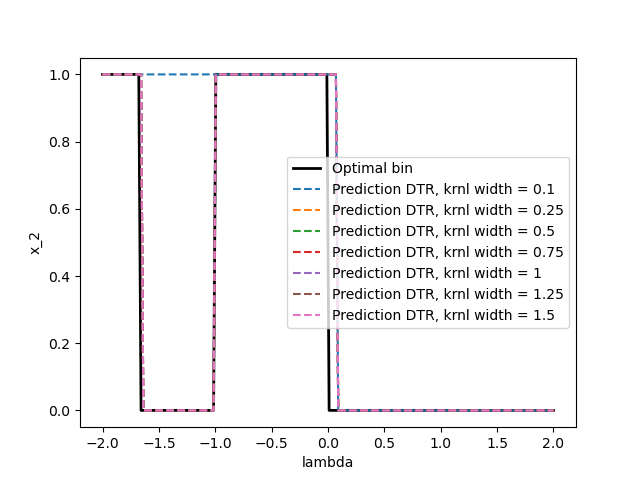

In [65]:
best_ind = [row[1] for row in best_cmb]

fig1 = plt.figure()
plt.plot(x_test, best_ind, color = 'black', linestyle = '-', label = "Optimal bin", linewidth =2) 
# plt.plot(x_test, best_ind_cts, color = 'red', linestyle = '-', label = "Optimal cts", linewidth =2) 
for kr_w in krnl_wdth[:]:
    # plt.plot(x_test, outcome_d[str(kr_w)], label = 'Prediction Lin Reg, krnl width = ' + str(kr_w), linestyle = '--', linewidth =1.5) 
    plt.plot(x_test, outcome_d[str(kr_w)+ 'DRT'], label = 'Prediction DTR, krnl width = ' + str(kr_w), linestyle = '--', linewidth =1.5) 
    # plt.plot(x_test, outcome_d[str(kr_w)+ 'SVM'], label = 'Prediction SVM, krnl width = ' + str(kr_w), linestyle = '--', linewidth =1.5) 
plt.legend()#bbox_to_anchor=(1.0, 1.0), loc='upper left') 
plt.xlabel("lambda")
plt.ylabel("x_2") 
plt.show()